In [88]:
import matplotlib.pyplot as plt
from decimal import Decimal
import random
import math

sl2 0.0005868552223846185
It 2
1.alpha 0.001333333333333333361088908949
sl2 0.0007812471432999298
It 3
3.alpha 0.001777777777777777814785211932
sl2 0.0010397949286986825
It 4
3.alpha 0.002370370370370370419713615909
sl2 0.0013836117519335032
It 5
3.alpha 0.003160493827160493892951487878
sl2 0.0018407395616749313
It 6
3.alpha 0.004213991769547325190601983836
sl2 0.002448380432155146
It 7
3.alpha 0.005618655692729766920802645113
sl2 0.0032558136854509943
101
21


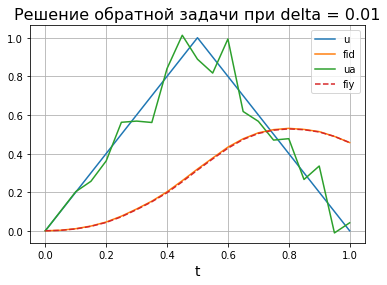

In [134]:
# идентификация граничного условия 
# нестационарная одномерная задача
# нелокальное возмущение граничного условия

# метод прогонки для трехдиагональной матрицы
def Prog(N, a, c, b, f, y):
    b[0] = b[0]/c[0]
    f[0] = f[0]/c[0]
    i = 1
    while i<N-1:
        c[i] = c[i] - b[i-1]*a[i]
        b[i] = b[i]/c[i]
        i+=1
    i = 1
    while i<N:
        f[i] = (f[i]+f[i-1]*a[i])/c[i]
        i += 1
    y[N-1] = f[N-1]
    i = N-2
    while i>=0:
        y[i] = b[i]*y[i+1]+f[i]
        i -= 1
    return

#граничное условие на правой границе
def AF(T,Tmax):
    AF = Decimal(2*T/Tmax)
    if (T>Decimal(0.5*Tmax)):
        AF= Decimal(2*(Tmax - T)/Tmax)
    return AF

delta = Decimal(0.0025) #уровень погрешности во входных данных
N = 101   #число узлов сетки по пространству
M = 21    #число узлов сетки по времени
xL = 0    # левый конец отрезка
xR = 1    # правый конец отрезка
Tmax = 1  #максимальное время
fi = [Decimal] * M   #точное разностное граничное условие
fid = [Decimal] * M  #возмущенное разностное граничное условие
fiy = [Decimal] * M
u = []   #точное решение обратной задачи (граничное условие)
ua = [Decimal] * M   #приближенное решение обратной задачи

a = [Decimal] * N
b = [Decimal] * N
c = [Decimal] * N
f = [Decimal] * N
q = [Decimal] * N
z = [Decimal] * N

x = [Decimal] * N
y = [Decimal] * N

#построение сетки
h = Decimal((xR - xL)/(N-1))
x = [xL + i*h for i in range(N)]

# Прямая задача

#граничный режим
tau = Decimal(Tmax/ (M-1))
i = 1
while i <= M:
    T = Decimal((i-1)*tau)
    u.append(AF(T,Tmax))
    i += 1
    
#начальное условие
T = 0
y = [0 for i in range(N)]

#новый временной слой
k = 1
while k < M:
    T = T+tau
    #коэффициенты разностной схемы
    #чисто неявная схема
    i = 1
    while i < N-1:
        a[i] = Decimal(1/h**2)
        b[i] = Decimal(1/h**2)
        c[i] = a[i]+b[i]+Decimal(1/tau)
        f[i] = Decimal(y[i]/tau)
        i += 1
    #граничное условие на левом и правом конце
    b[0] = Decimal(1/h**2)
    c[0] = b[0] + Decimal(1/tau)
    f[0] = Decimal(y[0]/tau)
    a[N-1] = 0
    c[N-1] = 1
    f[N-1] = u[k]
    #решение задачи на новом временном слое
    Prog(N,a,c,b,f,y)
    #решение на левой границе
    fi[k] = y[0]
    fid[k] = fi[k]
    k += 1

#зашумление краевой задачи
k = 1
while k < M:
    fid[k]=fi[k]+2*delta*(Decimal(random.uniform(0, 1)-0.5))
    k+=1

# Обратная задача

#нелокальное возмущение граничного условия 
#вспомогательная сеточная функция

#коэффициенты разностной схемы
i = 1
while i < N-1:
    a[i] = Decimal(1/h**2)
    b[i] = Decimal(1/h**2)
    c[i] = a[i]+b[i]+Decimal(1/tau)
    f[i] = Decimal(0)
    i += 1
    
#граничное условие на левом и правом конце
b[0] = Decimal(2/h**2)
c[0] = b[0] + Decimal(1/tau)
f[0] = Decimal(0)
a[N-1] = Decimal(0)
c[N-1] = Decimal(1)
f[N-1] = Decimal(1)

Prog(N,a,c,b,f,q)

#итерационный процесс по выбору параметра регуляризации

IT = 1
ITMAX = 100
alpha = Decimal(0.001)
QQ = Decimal(0.75)
while (IT <= 100):
    #начальное условие
    T = Decimal(0)
    i = 0
    while (i<N):
        y[i]=Decimal(0)
        i+=1
    ua[0] = y[N-1]
    
    #новый временной слой
    k = 1
    while (k<M):
        T = T+tau        
        #Коэффициенты разностной схемы
        #чисто неявная схема
        n = 1
        while (n<N-1):
            a[n] = Decimal(1/h**2)
            b[n] = Decimal(1/h**2)
            c[n] = a[n]+b[n]+Decimal(1/tau)
            f[n] = Decimal(y[n]/tau)
            n += 1
        #граничное условие на левом и правом конце
        b[0] = Decimal(2/h**2)
        c[0] = b[0] + Decimal(1/tau)
        f[0] = Decimal(y[0]/tau)
        a[N-1] = Decimal(0)
        c[N-1] = Decimal(1)
        f[N-1] = Decimal(0)
        #решение вспомогательной задачи на новом временном слое
        Prog(N,a,c,b,f,z)
        
        #решение на правой границе
        ua[k]=Decimal((fid[k]-z[0])/(alpha+q[0]))
        #решение во всех узлах
        l=0
        while l<N:
            y[l]=Decimal(z[l]+q[l]*ua[k])
            l+=1
        k+=1
    #решение прямой задачи с найденным граничным условием
    #начальное условие
    T=Decimal(0)
    l=0
    while l<N:
        y[l] = Decimal(0)
        l+=1
    fiy[0]=y[0]
    
    #новый временной слой
    k = 1
    while (k<M):
        T=T+tau
        #коэффициенты разностной схемы
        i = 1
        while (i<N-1):
            a[i] = Decimal(1/h**2)
            b[i] = Decimal(1/h**2)
            c[i] = a[i]+b[i]+Decimal(1/tau)
            f[i] = Decimal(y[i]/tau)
            i += 1
        #граничное условие на левом и правом конце
        b[0] = Decimal(2/h**2)
        c[0] = b[0] + Decimal(1/tau)
        f[0] = Decimal(y[0]/tau)
        a[N-1] = Decimal(0)
        c[N-1] = Decimal(1)
        f[N-1] = ua[k]
        #решение задачи на новом временном слое
        Prog(N,a,c,b,f,y)
        fiy[k]=y[0]
        k+=1
    #критерий выхода из итерационного процесса
    summ = Decimal(0)
    k = 1
    while (k<M):
        summ = summ + tau*(fiy[k]-fid[k])**2
        k+=1
    sl2 = math.sqrt(summ)
    print("sl2",sl2)
    if (IT>ITMAX):
        break
    if (IT == 1):
        IND = 0
        if (sl2<delta):
            IND = 1
            QQ = Decimal(1/QQ)
        alpha = Decimal(alpha*QQ)
        IT+=1
        print ("It",IT)
        print ('1.alpha',alpha)
    else:
        alpha = Decimal(alpha*QQ)
        if (IND == 0 and sl2 > delta):
            IT+=1
            print ("It",IT)
            print ('2.alpha',alpha)
        if (IND ==1 and sl2 < delta):
            IT+=1 
            print ("It",IT)
            print ('3.alpha',alpha)
        else:
            break
print(len(y))
print(len(u))
fid[0] = Decimal(0)
fiy[0] = Decimal(0)
m = [i*tau for i in range(M)]           
fig = plt.figure()
plt.plot(m, u, label = u'u')
plt.plot(m, fid, label = u'fid')
plt.plot(m, ua, label = u'ua')
plt.plot(m, fiy, label = u'fiy', linestyle='--')
plt.title('Решение обратной задачи при delta = 0.01',fontsize=16)
plt.xlabel('t',fontsize=14)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,y2))
plt.legend()
plt.grid(True)
